
# Тема №7. Использование автоэнкодера для решения задач семантической сегментации. Часть 3

## **Задание:**

## Скачать датасет по ссылке (снимки и маски, Version 1) . Обучить нейронную сеть предсказывать полноразмерную маску по загруженному снимку (см. теорию к предыдущим частям работы)

### Ссылка на датасет: https://landcover.ai.linuxpolska.com/#dataset



# Этап 1. Обработка исходных данных. Разделение на обучающую и тестовую выборку

Для работы с tiff-изображениями предлагается использовать библиотеку tifffile

In [9]:
pip install tifffile imagecodecs

     ---------------------------------------- 24.7/24.7 MB 8.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [4]:
root_directory = 'landcover\\'

In [12]:
import os
import cv2
import numpy as np
import glob

from pathlib import Path
from imutils.paths import list_images

from tqdm import tqdm

import numpy as np
from matplotlib import pyplot as plt
from patchify import patchify
import tifffile as tiff
from PIL import Image
import tensorflow as tf
from tensorflow import keras
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
import random

## 1.1. Проверка вывода растра и масок

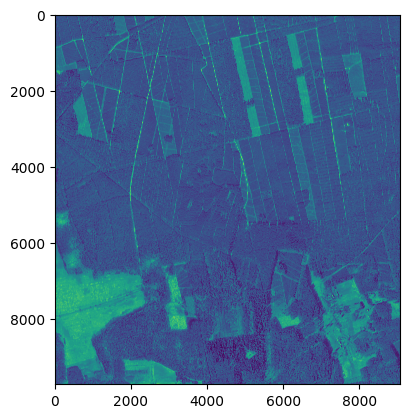

In [2]:
temp_img = tiff.imread('landcover\\images\\M-33-7-A-d-2-3.tif')
plt.imshow(temp_img[:,:,0])

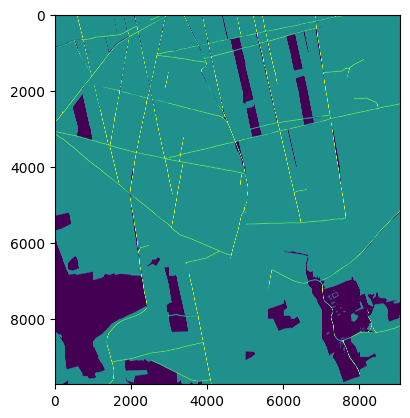

In [4]:
temp_mask = tiff.imread('landcover\\masks\\M-33-7-A-d-2-3.tif')
plt.imshow(temp_mask)

In [5]:
print(temp_img.shape)
print(temp_img.dtype)
print(temp_mask.shape)

labels, count = np.unique(temp_mask, return_counts=True) #Check for each channel. All chanels are identical
print("Labels are: ", labels, " and the counts are: ", count)

(9711, 9081, 3)
uint8
(9711, 9081)
Labels are:  [0 1 2 4]  and the counts are:  [10649007    60415 75869435  1606734]


## 1.2. Обрезка исходных растров на фрагменты (патчи) размером 256x256. Сохраните их в каталог на локальное хранилице

In [63]:
patch_size = 256

In [12]:
#Считываем изображения из подкаталога 'images'.
#Поскольку все изображения имеют разный размер, у нас есть 2 варианта: изменить размер или обрезать.
#Но некоторые изображения слишком большие, а некоторые маленькие. Изменение размера изменит размер реальных объектов.
#Поэтому мы обрезаем их до ближайшего размера, кратного 256, а затем 
#разделим все изображения на участки размером 256x256x3.
img_dir=root_directory+"images\\"

# Создадим директорию для хранения батчей
Path(root_directory + '256_patches\\images\\').mkdir(parents=True, exist_ok=True)

for path, subdirs, files in os.walk(img_dir):
    print(path)  
    dirname = path.split(os.path.sep)[-1]
    print(dirname)
    images = os.listdir(path) 
    print(images)
    for i, image_name in enumerate(images):  
        if image_name.endswith(".tif"):
            
            image = tiff.imread(path + "\\" + image_name)
            
            SIZE_X = (image.shape[1] // patch_size) * patch_size 
            SIZE_Y = (image.shape[0] // patch_size) * patch_size 
          
            image = image[0:SIZE_Y, 0:SIZE_X]

            print("Now patchifying image:", path + "\\" + image_name)
            patches_img = patchify(image, (256, 256, 3), step=256)
            
            for i in range(patches_img.shape[0]):
                for j in range(patches_img.shape[1]):
                    
                    single_patch_img = patches_img[i,j,:,:]
                    single_patch_img = single_patch_img[0]
          
                    tiff.imwrite(root_directory+"256_patches\\images\\" + image_name + 
                                 "patch_" + str(i) + str(j) + ".tif", single_patch_img, photometric='rgb')
            

landcover\images\

['M-33-20-D-c-4-2.tif', 'M-33-20-D-d-3-3.tif', 'M-33-32-B-b-4-4.tif', 'M-33-48-A-c-4-4.tif', 'M-33-7-A-d-2-3.tif', 'M-33-7-A-d-3-2.tif', 'M-34-32-B-a-4-3.tif', 'M-34-32-B-b-1-3.tif', 'M-34-5-D-d-4-2.tif', 'M-34-51-C-b-2-1.tif', 'M-34-51-C-d-4-1.tif', 'M-34-55-B-b-4-1.tif', 'M-34-56-A-b-1-4.tif', 'M-34-6-A-d-2-2.tif', 'M-34-65-D-a-4-4.tif', 'M-34-65-D-c-4-2.tif', 'M-34-65-D-d-4-1.tif', 'M-34-68-B-a-1-3.tif', 'M-34-77-B-c-2-3.tif', 'N-33-104-A-c-1-1.tif', 'N-33-119-C-c-3-3.tif', 'N-33-130-A-d-3-3.tif', 'N-33-130-A-d-4-4.tif', 'N-33-139-C-d-2-2.tif', 'N-33-139-C-d-2-4.tif', 'N-33-139-D-c-1-3.tif', 'N-33-60-D-c-4-2.tif', 'N-33-60-D-d-1-2.tif', 'N-33-96-D-d-1-1.tif', 'N-34-106-A-b-3-4.tif', 'N-34-106-A-c-1-3.tif', 'N-34-140-A-b-3-2.tif', 'N-34-140-A-b-4-2.tif', 'N-34-140-A-d-3-4.tif', 'N-34-140-A-d-4-2.tif', 'N-34-61-B-a-1-1.tif', 'N-34-66-C-c-4-3.tif', 'N-34-77-A-b-1-4.tif', 'N-34-94-A-b-2-4.tif', 'N-34-97-C-b-1-2.tif', 'N-34-97-D-c-2-4.tif']
Now patchifying image: landc

## 1.3. Обрезка исходных масок на фрагменты (патчи) размером 256x256. Сохраните их в каталог на локальное хранилице

In [9]:
mask_dir=root_directory + "masks\\"

# Создадим директорию для хранения батчей
Path(root_directory + '256_patches\\masks\\').mkdir(parents=True, exist_ok=True)

for path, subdirs, files in os.walk(mask_dir):
    print(path)
    dirname = path.split(os.path.sep)[-1]

    masks = os.listdir(path)
    for i, mask_name in enumerate(masks):  
        if mask_name.endswith(".tif"):  
            
            mask = cv2.imread(path + "\\" + mask_name)
            
            SIZE_X = (mask.shape[1] // patch_size) * patch_size
            SIZE_Y = (mask.shape[0] // patch_size) * patch_size
            
            mask = mask[0:SIZE_Y, 0:SIZE_X]
            
            print("Now patchifying mask:", path + "\\" + mask_name)
            patches_mask = patchify(mask, (256, 256, 1), step=256)
            
            for i in range(patches_mask.shape[0]):
                for j in range(patches_mask.shape[1]):
                    
                    single_patch_mask = patches_mask[i,j,:,:]
                    single_patch_mask = single_patch_mask[0]
                    tiff.imwrite(root_directory + "256_patches\\masks\\" +
                               mask_name + "patch_" + str(i) + str(j) + ".tif", single_patch_mask, photometric='minisblack')

landcover\masks\
Now patchifying mask: landcover\masks\\M-33-20-D-c-4-2.tif
Now patchifying mask: landcover\masks\\M-33-20-D-d-3-3.tif
Now patchifying mask: landcover\masks\\M-33-32-B-b-4-4.tif
Now patchifying mask: landcover\masks\\M-33-48-A-c-4-4.tif
Now patchifying mask: landcover\masks\\M-33-7-A-d-2-3.tif
Now patchifying mask: landcover\masks\\M-33-7-A-d-3-2.tif
Now patchifying mask: landcover\masks\\M-34-32-B-a-4-3.tif
Now patchifying mask: landcover\masks\\M-34-32-B-b-1-3.tif
Now patchifying mask: landcover\masks\\M-34-5-D-d-4-2.tif
Now patchifying mask: landcover\masks\\M-34-51-C-b-2-1.tif
Now patchifying mask: landcover\masks\\M-34-51-C-d-4-1.tif
Now patchifying mask: landcover\masks\\M-34-55-B-b-4-1.tif
Now patchifying mask: landcover\masks\\M-34-56-A-b-1-4.tif
Now patchifying mask: landcover\masks\\M-34-6-A-d-2-2.tif
Now patchifying mask: landcover\masks\\M-34-65-D-a-4-4.tif
Now patchifying mask: landcover\masks\\M-34-65-D-c-4-2.tif
Now patchifying mask: landcover\masks\\M-34

## 1.4. Проверка патчей масок и исходного растра на соответствие

In [15]:
img_dir = 'landcover\\256_patches\\images\\'
mask_dir = 'landcover\\256_patches\\masks\\'

img_list   = list(list_images(img_dir))
msk_list   = list(list_images(mask_dir))

img_count  = len(img_list)

print(f'Image patches count: {len(img_list)}')
print(f'Masks patches count: {len(msk_list)}')

Image patches count: 41646
Masks patches count: 41646


<Figure size 1200x800 with 0 Axes>

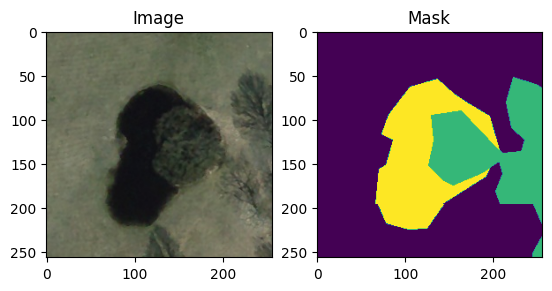

In [19]:
import random
from matplotlib import pyplot as plt

img_num = random.randint(0, img_count - 1)

img_for_plot = cv2.cvtColor(
    cv2.imread(img_patch_list[img_num]), 
    cv2.COLOR_BGR2RGB
)

mask_for_plot = tiff.imread(msk_list[img_num])

fig = plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
figure, axis = plt.subplots(1, 2)

axis[0].imshow(img_for_plot, vmin=0,vmax=100)
axis[0].set_title('Image')

axis[1].imshow(mask_for_plot)
axis[1].set_title('Mask')

plt.show()

## 1.5. Отсев неинформативных растров и соответствующих масок

Пропускаем изображения на которых один класс заднимает более 95% площади

In [31]:
# Скопируем изображения и маски с реальной информацией в новую папку.

Path(root_directory + '256_patches\\data\\images\\').mkdir(parents=True, exist_ok=True)
Path(root_directory + '256_patches\\data\\masks\\').mkdir(parents=True, exist_ok=True)

useless=0
for i in tqdm(range(len(img_list))): 
    img_name  = img_list[i].split('\\')[-1]
    mask_name = msk_list[i].split('\\')[-1]
      
    temp_image = tiff.imread(img_list[i])
    temp_mask  = tiff.imread(msk_list[i])
    
    #temp_mask=temp_mask.astype(np.uint8)
    
    val, counts = np.unique(temp_mask, return_counts=True)
    
    if (1 - (counts[0]/counts.sum())) > 0.05:  # От 5% полезной площади
        tiff.imwrite(root_directory + '256_patches\\data\\images\\' + img_name, temp_image, photometric='rgb')
        tiff.imwrite(root_directory + '256_patches\\data\\masks\\' + mask_name, temp_mask, photometric='minisblack')
        
    else:
        useless += 1

print("Total useful images are: ", len(img_list) - useless)
print("Total useless images are: ", useless)

100%|████████████████████████████████████████████████████████████████████████████| 41646/41646 [11:55<00:00, 58.20it/s]

Total useful images are:  21924
Total useless images are:  19722


## 1.6. Формирование папок с обучающей и валидационной выборкой

In [40]:
input_folder = root_directory + '256_patches\\data\\'
output_folder = root_directory + '256_patches\\splitted_data\\'
Path(output_folder).mkdir(parents=True, exist_ok=True)

In [41]:
import splitfolders
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.75, .25), group_prefix=None) # default values

Copying files: 43848 files [07:12, 101.44 files/s]


In [42]:
import shutil

src_train_img = root_directory + '256_patches\\splitted_data\\train\\images\\'
src_train_msk = root_directory + '256_patches\\splitted_data\\train\\masks\\'
src_val_img   = root_directory + '256_patches\\splitted_data\\val\\images\\'
src_val_msk   = root_directory + '256_patches\\splitted_data\\val\\masks\\'

dst_train_img = root_directory + '256_patches\\dataset\\train_image\\train\\'
dst_train_msk = root_directory + '256_patches\\dataset\\train_mask\\train\\'
dst_val_img   = root_directory + '256_patches\\dataset\\val_image\\val\\'
dst_val_msk   = root_directory + '256_patches\\dataset\\val_mask\\val\\'

shutil.copytree(src_train_img, dst_train_img)
shutil.copytree(src_train_msk, dst_train_msk)
shutil.copytree(src_val_img, dst_val_img)
shutil.copytree(src_val_msk, dst_val_msk)

'landcover\\256_patches\\dataset\\val_mask\\val\\'

In [46]:
!tree {root_directory}256_patches\\dataset\\

Структура папок тома SSD Disk
Серийный номер тома: 6E57-88A9
C:\USERS\FLEXL\DESKTOP\DEEPLEARNING\HOMEWORK7\LANDCOVER\256_PATCHES\DATASET
+---train_image
¦   L---train
+---train_mask
¦   L---train
+---val_image
¦   L---val
L---val_mask
    L---val


# Этап 2. Загрузка тренировочной и тестовой выборки. Подготовка к обучению. Разработка архитектуры модели нейронной сети

In [1]:
import cv2
import os
import pickle
import numpy as np
from pathlib import Path
from PIL import Image
from patchify import patchify
from matplotlib import pyplot as plt
import segmentation_models as sm
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.utils import to_categorical

# Слои для проектирования своей модели
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, Conv2DTranspose, BatchNormalization, Dropout, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam

import tifffile as tiff
import tensorflow as tf
sm.set_framework('tf.keras')
from tensorflow.python.client import device_lib

import tensorflow
tensorflow.compat.v1.enable_eager_execution()
print(f'Tensorflow version: {tensorflow.__version__}')

import sklearn
print(f'Sklearn version: {sklearn.__version__}')

import pandas as pd

import plotly.io as pio
import plotly.graph_objects as go
pio.renderers.default = "png"

print(f'Segmentaion models framework: {sm.framework()}')
print(f'Local machine devices: {device_lib.list_local_devices()}')

Segmentation Models: using `keras` framework.
Tensorflow version: 2.10.0
Sklearn version: 1.2.2
Segmentaion models framework: tf.keras
Local machine devices: [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1987051476513713425
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5717884928
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5445581375927816934
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:02:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


## 2.1. Инициализация сформированной выборки

In [5]:
!tree {root_directory}256_patches\\dataset\\

Структура папок тома SSD Disk
Серийный номер тома: 6E57-88A9
C:\USERS\FLEXL\DESKTOP\DEEPLEARNING\HOMEWORK7\LANDCOVER\256_PATCHES\DATASET
+---train_image
¦   L---train
+---train_mask
¦   L---train
+---val_image
¦   L---val
L---val_mask
    L---val


In [ ]:
train_img_dir = root_directory + '256_patches\\dataset\\train_image\\'
train_msk_dir = root_directory + '256_patches\\dataset\\train_mask\\'
val_img_dir   = root_directory + '256_patches\\dataset\\val_image\\'
val_msk_dir   = root_directory + '256_patches\\dataset\\val_mask\\'

img_paths = list(list_images(train_img_dir))
msk_paths = list(list_images(train_msk_dir))

#### Проверка

<Figure size 1200x800 with 0 Axes>

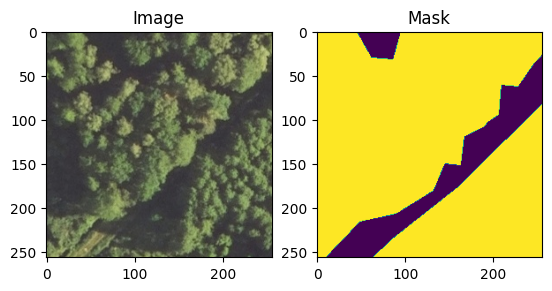

In [75]:
import random

img_num = random.randint(0, img_count - 1)

img_for_plot = cv2.cvtColor(
    cv2.imread(img_paths[img_num]), 
    cv2.COLOR_BGR2RGB
)

mask_for_plot = tiff.imread(msk_paths[img_num])

fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
 
figure, axis = plt.subplots(1, 2)

axis[0].imshow(img_for_plot, cmap=plt.get_cmap('gray'), vmin=0, vmax=100)
axis[0].set_title('Image')

axis[1].imshow(mask_for_plot)
axis[1].set_title('Mask')

plt.show()

## 2.2. Предобработка обучающей выборки

In [7]:
scaler = MinMaxScaler()

BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

### Нормализация исходного патча и маски

In [8]:
def preprocess_data(img, mask, num_class):
    img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
    img = preprocess_input(img) 
    mask = mask[:,:,:,0]
    mask = to_categorical(mask, num_class)
      
    return (img, mask)

## 2.3. Формирование последовательной загрузки набора данных с жесткого диска для обучения модели, используя Keras.ImageDataGenerator()

In [9]:
seed=24
batch_size=20
n_classes=5

train_dataset_path = 'dataset1\\train'
val_dataset_path = 'dataset1\\val'

In [10]:
from keras.preprocessing.image import ImageDataGenerator
def trainGenerator(train_img_path, train_mask_path, num_class):
    img_data_gen_args = dict(horizontal_flip=True,
                      vertical_flip=True)
    
    image_datagen = ImageDataGenerator(**img_data_gen_args)
    image_generator = image_datagen.flow_from_directory(
        train_img_path,
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    
    target_datagen = ImageDataGenerator(**img_data_gen_args)
    target_generator = target_datagen.flow_from_directory(
        train_mask_path,
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    
    train_generator = zip(image_generator, target_generator)
    
    for (img, target) in train_generator:
        processed_img, processed_target = preprocess_data(img, target, num_class)
        yield (processed_img, processed_target)

In [29]:
train_img_gen = trainGenerator(train_img_dir, train_msk_dir, num_class=n_classes)
val_img_gen = trainGenerator(val_img_dir, val_msk_dir, num_class=n_classes)

train_steps_count = len(list(list_images(train_img_dir + '\\' + 'train'))) // batch_size
val_steps_count = len(list(list_images(val_img_dir + '\\' + 'val'))) // batch_size
print(f'Train steps per epoch: {train_steps_count}')
print(f'Val steps per epoch: {val_steps_count}')

Train steps per epoch: 822
Val steps per epoch: 274


#### Проверка:

Found 16443 images belonging to 1 classes.
Found 16443 images belonging to 1 classes.
Found 5481 images belonging to 1 classes.
Found 5481 images belonging to 1 classes.
Train image shape: (20, 256, 256, 3)
Train mask shape: (20, 256, 256, 5)
Val image shape: (20, 256, 256, 3)
Val mask shape: (20, 256, 256, 5)


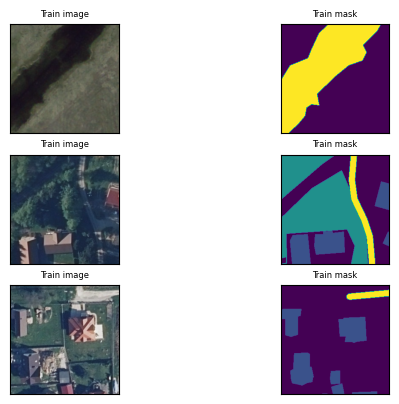

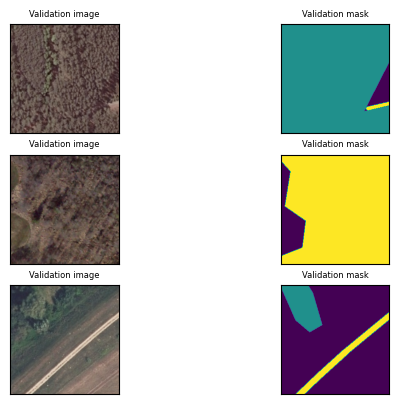

In [112]:
train_img_batch, train_mask_batch = next(train_img_gen)
train_mask_batch_argmax = np.argmax(train_mask_batch, axis=3) 

val_img_batch, val_mask_batch = next(val_img_gen)
val_mask_batch_argmax = np.argmax(val_mask_batch, axis=3) 

print(f'Train image shape: {train_img_batch.shape}')
print(f'Train mask shape: {train_mask_batch.shape}')
print(f'Val image shape: {val_img_batch.shape}')
print(f'Val mask shape: {val_mask_batch.shape}')

img_plot_count = 3

fig1, axis1 = plt.subplots(img_plot_count, 2)

for i in range(img_plot_count):
    axis1[i][0].imshow(train_img_batch[i])
    axis1[i][0].set_title('Train image', fontsize = 6)
    axis1[i][0].axes.xaxis.set_visible(False)
    axis1[i][0].axes.yaxis.set_visible(False)
    
    axis1[i][1].imshow(train_mask_batch_argmax[i])
    axis1[i][1].set_title('Train mask', fontsize = 6)
    axis1[i][1].axes.xaxis.set_visible(False)
    axis1[i][1].axes.yaxis.set_visible(False)

fig2, axis2 = plt.subplots(img_plot_count, 2)

for i in range(img_plot_count):
    axis2[i][0].imshow(val_img_batch[i])
    axis2[i][0].set_title('Validation image', fontsize = 6)
    axis2[i][0].axes.xaxis.set_visible(False)
    axis2[i][0].axes.yaxis.set_visible(False)
    
    axis2[i][1].imshow(val_mask_batch_argmax[i])
    axis2[i][1].set_title('Validation mask', fontsize = 6)
    axis2[i][1].axes.xaxis.set_visible(False)
    axis2[i][1].axes.yaxis.set_visible(False)

## 2.4. Разработка архитектуры и компиляция модели

In [18]:
metrics = ['accuracy', sm.metrics.iou_score, sm.metrics.FScore()]
unet_3_landcover = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation='softmax')

unet_3_landcover.compile(optimizer=Adam(learning_rate=0.0001), loss=sm.losses.categorical_focal_dice_loss, metrics=metrics)
unet_3_landcover.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d_68 (ZeroPadding  (None, None, None,   0          ['bn_data[0][0]']                
 2D)                            3)                                                          

                                                                                                  
 stage1_unit3_bn1 (BatchNormali  (None, None, None,   256        ['add_33[0][0]']                 
 zation)                        64)                                                               
                                                                                                  
 stage1_unit3_relu1 (Activation  (None, None, None,   0          ['stage1_unit3_bn1[0][0]']       
 )                              64)                                                               
                                                                                                  
 zero_padding2d_74 (ZeroPadding  (None, None, None,   0          ['stage1_unit3_relu1[0][0]']     
 2D)                            64)                                                               
                                                                                                  
 stage1_un

                                128)                              'add_35[0][0]']                 
                                                                                                  
 stage2_unit3_bn1 (BatchNormali  (None, None, None,   512        ['add_36[0][0]']                 
 zation)                        128)                                                              
                                                                                                  
 stage2_unit3_relu1 (Activation  (None, None, None,   0          ['stage2_unit3_bn1[0][0]']       
 )                              128)                                                              
                                                                                                  
 zero_padding2d_80 (ZeroPadding  (None, None, None,   0          ['stage2_unit3_relu1[0][0]']     
 2D)                            128)                                                              
          

 add_39 (Add)                   (None, None, None,   0           ['stage3_unit1_conv2[0][0]',     
                                256)                              'stage3_unit1_sc[0][0]']        
                                                                                                  
 stage3_unit2_bn1 (BatchNormali  (None, None, None,   1024       ['add_39[0][0]']                 
 zation)                        256)                                                              
                                                                                                  
 stage3_unit2_relu1 (Activation  (None, None, None,   0          ['stage3_unit2_bn1[0][0]']       
 )                              256)                                                              
                                                                                                  
 zero_padding2d_86 (ZeroPadding  (None, None, None,   0          ['stage3_unit2_relu1[0][0]']     
 2D)      

                                                                                                  
 stage3_unit5_bn1 (BatchNormali  (None, None, None,   1024       ['add_42[0][0]']                 
 zation)                        256)                                                              
                                                                                                  
 stage3_unit5_relu1 (Activation  (None, None, None,   0          ['stage3_unit5_bn1[0][0]']       
 )                              256)                                                              
                                                                                                  
 zero_padding2d_92 (ZeroPadding  (None, None, None,   0          ['stage3_unit5_relu1[0][0]']     
 2D)                            256)                                                              
                                                                                                  
 stage3_un

                                512)                              'stage4_unit1_sc[0][0]']        
                                                                                                  
 stage4_unit2_bn1 (BatchNormali  (None, None, None,   2048       ['add_45[0][0]']                 
 zation)                        512)                                                              
                                                                                                  
 stage4_unit2_relu1 (Activation  (None, None, None,   0          ['stage4_unit2_bn1[0][0]']       
 )                              512)                                                              
                                                                                                  
 zero_padding2d_98 (ZeroPadding  (None, None, None,   0          ['stage4_unit2_relu1[0][0]']     
 2D)                            512)                                                              
          

                                                                                                  
 decoder_stage0b_relu (Activati  (None, None, None,   0          ['decoder_stage0b_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 decoder_stage1_upsampling (UpS  (None, None, None,   0          ['decoder_stage0b_relu[0][0]']   
 ampling2D)                     256)                                                              
                                                                                                  
 decoder_stage1_concat (Concate  (None, None, None,   0          ['decoder_stage1_upsampling[0][0]
 nate)                          384)                             ',                               
                                                                  'stage3_unit1_relu1[0][0]']     
          

                                16)                              ']                               
                                                                                                  
 decoder_stage4a_bn (BatchNorma  (None, None, None,   64         ['decoder_stage4a_conv[0][0]']   
 lization)                      16)                                                               
                                                                                                  
 decoder_stage4a_relu (Activati  (None, None, None,   0          ['decoder_stage4a_bn[0][0]']     
 on)                            16)                                                               
                                                                                                  
 decoder_stage4b_conv (Conv2D)  (None, None, None,   2304        ['decoder_stage4a_relu[0][0]']   
                                16)                                                               
          

# Этап 3. Обучение модели и оценка точности

In [19]:
from tqdm.keras import TqdmCallback
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, CSVLogger, BackupAndRestore

# Создать директорию для бэкапов модели
backup_dir = 'tmp/backup'
Path(backup_dir).mkdir(parents=True, exist_ok=True)

my_callbacks = [
    EarlyStopping(monitor='val_loss', patience=2, verbose=1),
    #ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=0, min_lr=0.0001),
    BackupAndRestore(backup_dir),
    CSVLogger("unet_3_landscape_history.csv", append=True),
    TqdmCallback(verbose=1),
]

unet_3_landcover_history = unet_3_landcover.fit(
    train_img_gen,
    steps_per_epoch=train_steps_count,
    epochs=10,
    verbose=0, 
    validation_steps=val_steps_count,
    validation_data=val_img_gen,
    callbacks=my_callbacks
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Found 5481 images belonging to 1 classes.
Found 5481 images belonging to 1 classes.
Epoch 10: early stopping


In [20]:
unet_3_landcover.save('unet_3_landcover.h5', save_format='h5')

## 3.1. Визуализация процесса обучения

In [21]:
def print_stats(history_path, name):
    history = pd.read_csv(history_path)
    fig, axs = plt.subplots(4, 1, sharex=True)
    
    fig.set_figwidth(15)
    fig.set_figheight(15)
    fig.suptitle(name)
    plt.xlabel('Epochs', fontsize=10)
    
    axs[0].set_title("Training and validation loss")
    axs[0].plot(history['loss'])
    axs[0].plot(history['val_loss'])
    axs[0].set_ylabel('Loss')
    axs[0].legend(['Training loss', 'Validation loss'], loc="upper right")

    axs[1].set_title("Training and validation accuracy")
    axs[1].plot(history['accuracy'])
    axs[1].plot(history['val_accuracy'])
    axs[1].set_ylabel('Accuracy')
    axs[1].legend(['Training accuracy', 'Validation accuracy'], loc="lower right")

    axs[2].set_title("Training and validation IOU score")
    axs[2].plot(history['iou_score'])
    axs[2].plot(history['val_iou_score'])
    axs[2].set_ylabel('IOU score')
    axs[2].legend(['Training IOU score', 'Validation IOU score'], loc="lower right")

    axs[3].set_title("Training and validation F1 score")
    axs[3].plot(history['f1-score'])
    axs[3].plot(history['val_f1-score'])
    axs[3].set_ylabel('F1 score')
    axs[3].legend(['Training F1 score', 'Validation F1 score'], loc="lower right")

    fig.subplots_adjust(bottom=0.1, top=0.95)

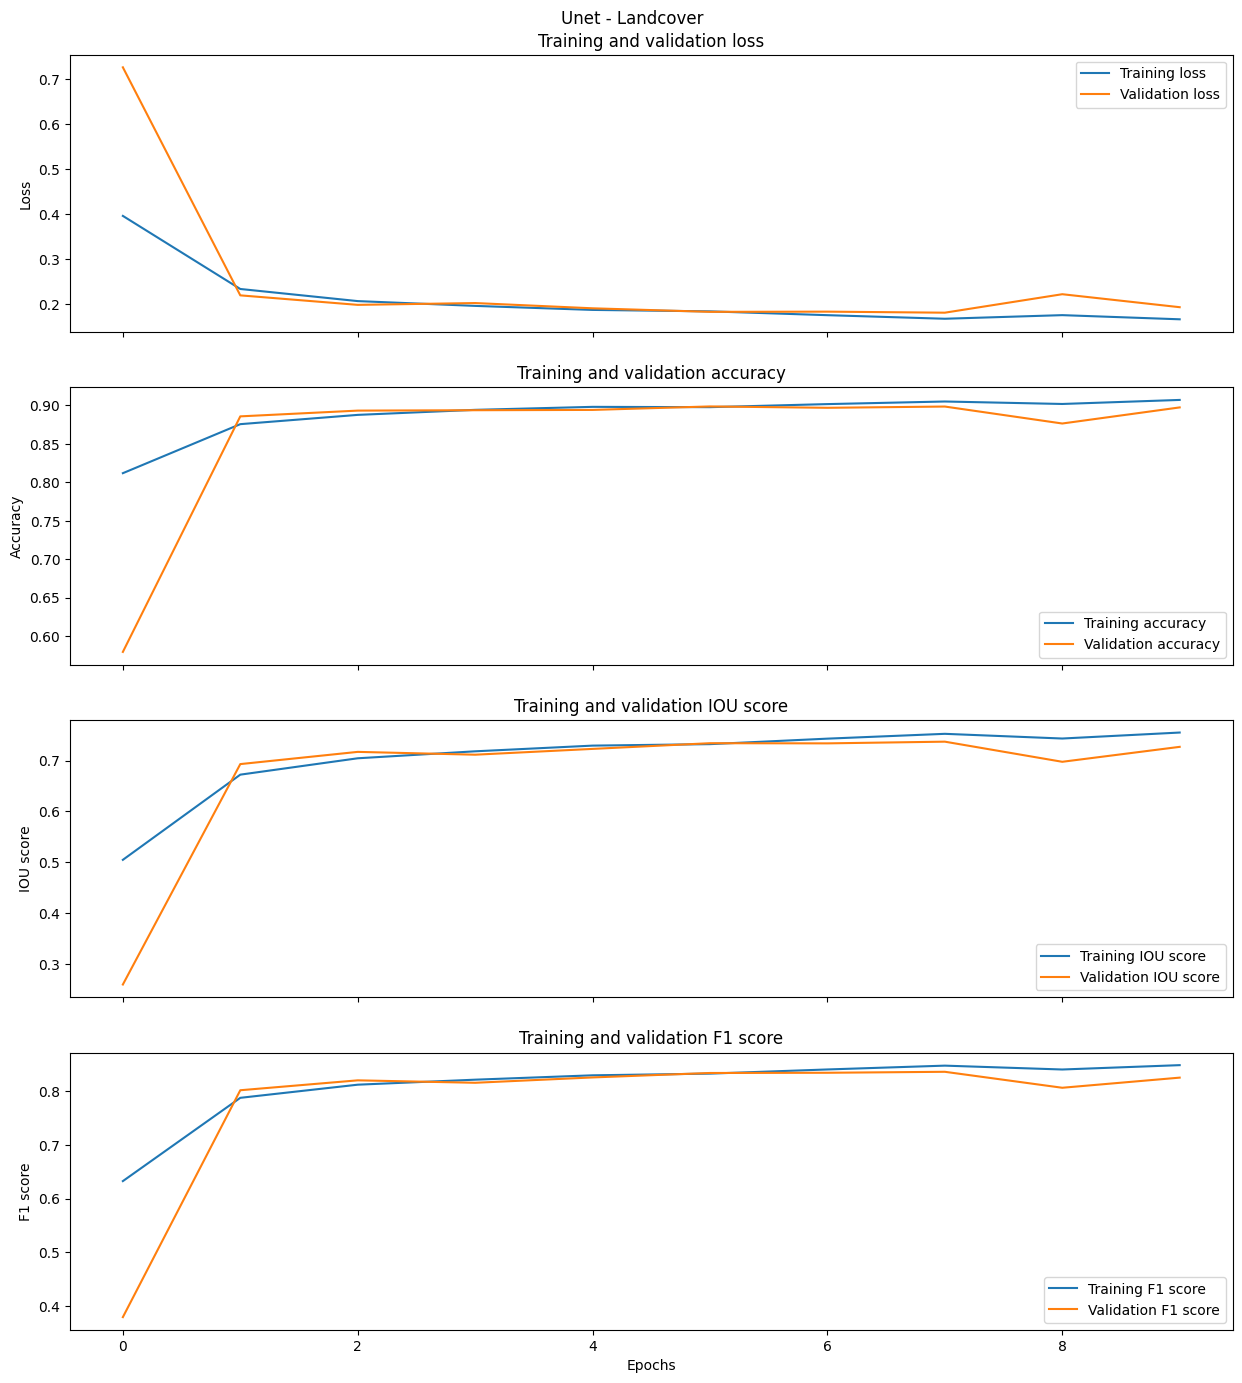

In [22]:
print_stats('unet_3_landscape_history.csv', 'Unet - Landcover')

## 3.2. Оценка оценка точности по валидационной выборке

In [24]:
from keras.models import load_model
unet_3_landcover = load_model("unet_3_landcover.h5", compile=False)

metrics = ['accuracy', sm.metrics.iou_score, sm.metrics.FScore()]
unet_3_landcover.compile(metrics=metrics)

In [31]:
# Оценка моделей на основе валидационной выборки
test_pred_unet_3 = unet_3_landcover.evaluate(
    val_img_gen, 
    steps=len(list(list_images(val_img_dir + '\\' + 'val')))
)

5481/5481 [==============================] - 1478s 270ms/step - loss: 0.0000e+00 - accuracy: 0.8969 - iou_score: 0.7277 - f1-score: 0.8263


In [32]:
def print_model_evaluation(model_name, pred):
    print(f'Evaluation of {model_name}')
    print(F"Mean Accuracy = {pred[1]}") 
    print(F"Mean IOU = {pred[2]}") 
    print(F"Mean FScore = {pred[3]}") 
    print()

print_model_evaluation('Unet - Landcover', test_pred_unet_3)

Evaluation of Unet - Landcover
Mean Accuracy = 0.8969429731369019
Mean IOU = 0.7276754975318909
Mean FScore = 0.8263320326805115



## 3.3. Визуализация предсказаний и сравнение их с оригинальными масками

Found 5481 images belonging to 1 classes.
Found 5481 images belonging to 1 classes.
1/1 [==============================] - 0s 49ms/step


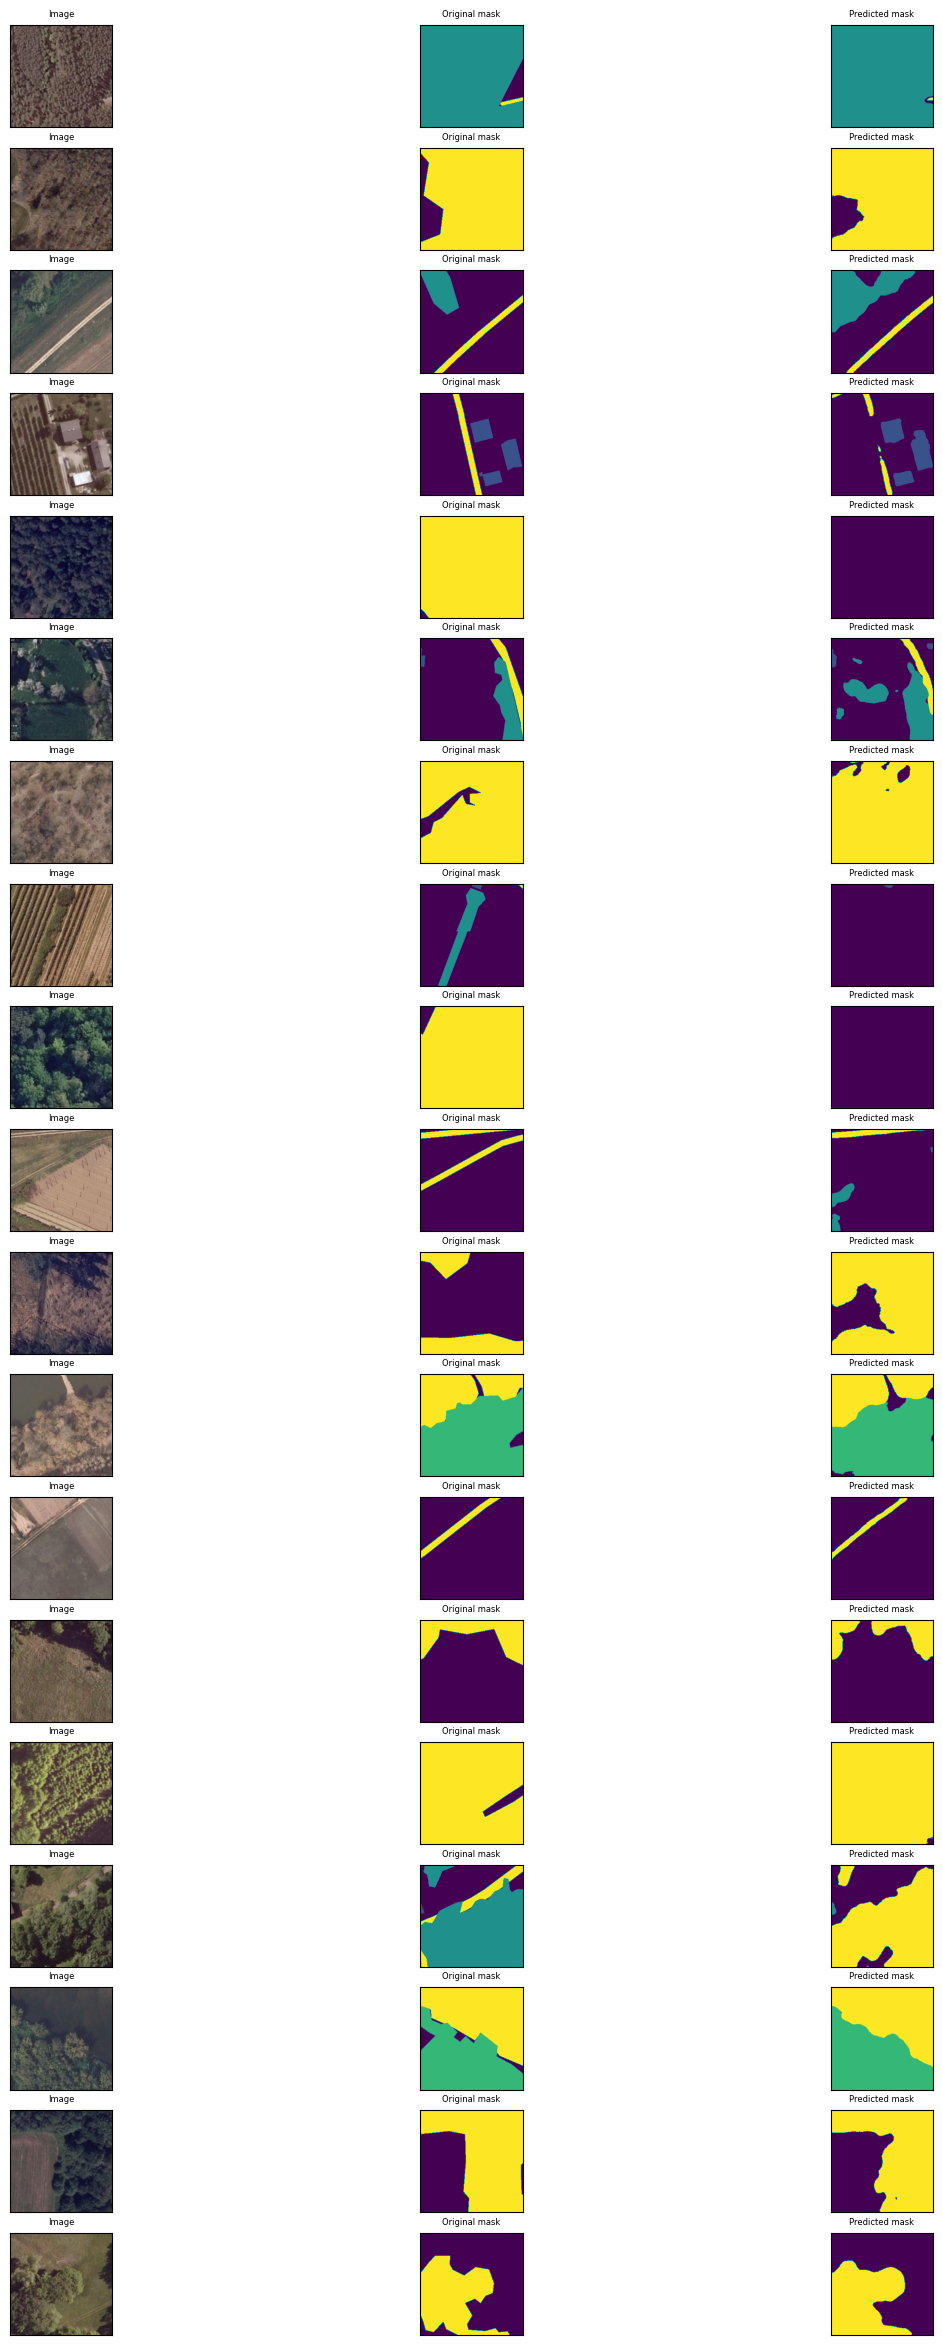

In [36]:
val_img_gen = trainGenerator(val_img_dir, val_msk_dir, num_class=6)
image_batch, mask_batch = next(val_img_gen)
mask_batch = np.argmax(mask_batch, axis=3) 

mask = np.argmax(unet_3_landcover.predict(image_batch), axis=3)

image_count = image_batch.shape[0] - 1

fig, axis = plt.subplots(image_count, 3)
fig.set_figwidth(15)
fig.set_figheight(30)

for i in range(image_count):
    axis[i][0].imshow(image_batch[i])
    axis[i][0].set_title('Image', fontsize = 6)
    axis[i][0].axes.xaxis.set_visible(False)
    axis[i][0].axes.yaxis.set_visible(False)

    axis[i][1].imshow(mask_batch[i])
    axis[i][1].set_title("Original mask", fontsize = 6)
    axis[i][1].axes.xaxis.set_visible(False)
    axis[i][1].axes.yaxis.set_visible(False)

    axis[i][2].imshow(mask[i])
    axis[i][2].set_title("Predicted mask", fontsize = 6)
    axis[i][2].axes.xaxis.set_visible(False)
    axis[i][2].axes.yaxis.set_visible(False)

plt.show()

# Этап 4. Обработка цельного снимка с помощью обученной модели

См. предыдущую часть работы

In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
import segmentation_models as sm
from keras.metrics import MeanIoU
from keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tifffile as tiff

Segmentation Models: using `keras` framework.


In [2]:
"""

Original code is from the following source. It comes with MIT License so please mention
the original reference when sharing.

The original code has been modified to fix a couple of bugs and chunks of code
unnecessary for smooth tiling are removed. 

# MIT License
# Copyright (c) 2017 Vooban Inc.
# Coded by: Guillaume Chevalier
# Source to original code and license:
#     https://github.com/Vooban/Smoothly-Blend-Image-Patches
#     https://github.com/Vooban/Smoothly-Blend-Image-Patches/blob/master/LICENSE

"""
"""Perform smooth predictions on an image from tiled prediction patches."""


import numpy as np
import scipy.signal
from tqdm import tqdm

import gc


if __name__ == '__main__':
    import matplotlib.pyplot as plt
    PLOT_PROGRESS = False
    # See end of file for the rest of the __main__.
else:
    PLOT_PROGRESS = False


def _spline_window(window_size, power=2):
    """
    Squared spline (power=2) window function:
    https://www.wolframalpha.com/input/?i=y%3Dx**2,+y%3D-(x-2)**2+%2B2,+y%3D(x-4)**2,+from+y+%3D+0+to+2
    """
    intersection = int(window_size/4)
    wind_outer = (abs(2*(scipy.signal.triang(window_size))) ** power)/2
    wind_outer[intersection:-intersection] = 0

    wind_inner = 1 - (abs(2*(scipy.signal.triang(window_size) - 1)) ** power)/2
    wind_inner[:intersection] = 0
    wind_inner[-intersection:] = 0

    wind = wind_inner + wind_outer
    wind = wind / np.average(wind)
    return wind


cached_2d_windows = dict()
def _window_2D(window_size, power=2):
    """
    Make a 1D window function, then infer and return a 2D window function.
    Done with an augmentation, and self multiplication with its transpose.
    Could be generalized to more dimensions.
    """
    # Memoization
    global cached_2d_windows
    key = "{}_{}".format(window_size, power)
    if key in cached_2d_windows:
        wind = cached_2d_windows[key]
    else:
        wind = _spline_window(window_size, power)
        wind = np.expand_dims(np.expand_dims(wind, 1), 1)      #SREENI: Changed from 3, 3, to 1, 1 
        wind = wind * wind.transpose(1, 0, 2)
        if PLOT_PROGRESS:
            # For demo purpose, let's look once at the window:
            plt.imshow(wind[:, :, 0], cmap="viridis")
            plt.title("2D Windowing Function for a Smooth Blending of "
                      "Overlapping Patches")
            plt.show()
        cached_2d_windows[key] = wind
    return wind


def _pad_img(img, window_size, subdivisions):
    """
    Add borders to img for a "valid" border pattern according to "window_size" and
    "subdivisions".
    Image is an np array of shape (x, y, nb_channels).
    """
    aug = int(round(window_size * (1 - 1.0/subdivisions)))
    more_borders = ((aug, aug), (aug, aug), (0, 0))
    ret = np.pad(img, pad_width=more_borders, mode='reflect')
    # gc.collect()

    if PLOT_PROGRESS:
        # For demo purpose, let's look once at the window:
        plt.imshow(ret)
        plt.title("Padded Image for Using Tiled Prediction Patches\n"
                  "(notice the reflection effect on the padded borders)")
        plt.show()
    return ret


def _unpad_img(padded_img, window_size, subdivisions):
    """
    Undo what's done in the `_pad_img` function.
    Image is an np array of shape (x, y, nb_channels).
    """
    aug = int(round(window_size * (1 - 1.0/subdivisions)))
    ret = padded_img[
        aug:-aug,
        aug:-aug,
        :
    ]
    # gc.collect()
    return ret


def _rotate_mirror_do(im):
    """
    Duplicate an np array (image) of shape (x, y, nb_channels) 8 times, in order
    to have all the possible rotations and mirrors of that image that fits the
    possible 90 degrees rotations.
    It is the D_4 (D4) Dihedral group:
    https://en.wikipedia.org/wiki/Dihedral_group
    """
    mirrs = []
    mirrs.append(np.array(im))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=1))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=2))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=3))
    im = np.array(im)[:, ::-1]
    mirrs.append(np.array(im))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=1))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=2))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=3))
    return mirrs


def _rotate_mirror_undo(im_mirrs):
    """
    merges a list of 8 np arrays (images) of shape (x, y, nb_channels) generated
    from the `_rotate_mirror_do` function. Each images might have changed and
    merging them implies to rotated them back in order and average things out.
    It is the D_4 (D4) Dihedral group:
    https://en.wikipedia.org/wiki/Dihedral_group
    """
    origs = []
    origs.append(np.array(im_mirrs[0]))
    origs.append(np.rot90(np.array(im_mirrs[1]), axes=(0, 1), k=3))
    origs.append(np.rot90(np.array(im_mirrs[2]), axes=(0, 1), k=2))
    origs.append(np.rot90(np.array(im_mirrs[3]), axes=(0, 1), k=1))
    origs.append(np.array(im_mirrs[4])[:, ::-1])
    origs.append(np.rot90(np.array(im_mirrs[5]), axes=(0, 1), k=3)[:, ::-1])
    origs.append(np.rot90(np.array(im_mirrs[6]), axes=(0, 1), k=2)[:, ::-1])
    origs.append(np.rot90(np.array(im_mirrs[7]), axes=(0, 1), k=1)[:, ::-1])
    return np.mean(origs, axis=0)


def _windowed_subdivs(padded_img, window_size, subdivisions, nb_classes, pred_func):
    """
    Create tiled overlapping patches.
    Returns:
        5D numpy array of shape = (
            nb_patches_along_X,
            nb_patches_along_Y,
            patches_resolution_along_X,
            patches_resolution_along_Y,
            nb_output_channels
        )
    Note:
        patches_resolution_along_X == patches_resolution_along_Y == window_size
    """
    WINDOW_SPLINE_2D = _window_2D(window_size=window_size, power=2)

    step = int(window_size/subdivisions)
    padx_len = padded_img.shape[0]
    pady_len = padded_img.shape[1]
    subdivs = []

    for i in range(0, padx_len-window_size+1, step):
        subdivs.append([])
        for j in range(0, pady_len-window_size+1, step):            #SREENI: Changed padx to pady (Bug in original code)
            patch = padded_img[i:i+window_size, j:j+window_size, :]
            subdivs[-1].append(patch)

    # Here, `gc.collect()` clears RAM between operations.
    # It should run faster if they are removed, if enough memory is available.
    gc.collect()
    subdivs = np.array(subdivs)
    gc.collect()
    a, b, c, d, e = subdivs.shape
    subdivs = subdivs.reshape(a * b, c, d, e)
    gc.collect()

    subdivs = pred_func(subdivs)
    gc.collect()
    subdivs = np.array([patch * WINDOW_SPLINE_2D for patch in subdivs])
    gc.collect()

    # Such 5D array:
    subdivs = subdivs.reshape(a, b, c, d, nb_classes)
    gc.collect()

    return subdivs


def _recreate_from_subdivs(subdivs, window_size, subdivisions, padded_out_shape):
    """
    Merge tiled overlapping patches smoothly.
    """
    step = int(window_size/subdivisions)
    padx_len = padded_out_shape[0]
    pady_len = padded_out_shape[1]

    y = np.zeros(padded_out_shape)

    a = 0
    for i in range(0, padx_len-window_size+1, step):
        b = 0
        for j in range(0, pady_len-window_size+1, step):                #SREENI: Changed padx to pady (Bug in original code)
            windowed_patch = subdivs[a, b]
            y[i:i+window_size, j:j+window_size] = y[i:i+window_size, j:j+window_size] + windowed_patch
            b += 1
        a += 1
    return y / (subdivisions ** 2)


def predict_img_with_smooth_windowing(input_img, window_size, subdivisions, nb_classes, pred_func):
    """
    Apply the `pred_func` function to square patches of the image, and overlap
    the predictions to merge them smoothly.
    See 6th, 7th and 8th idea here:
    http://blog.kaggle.com/2017/05/09/dstl-satellite-imagery-competition-3rd-place-winners-interview-vladimir-sergey/
    """
    pad = _pad_img(input_img, window_size, subdivisions)
    pads = _rotate_mirror_do(pad)

    # Note that the implementation could be more memory-efficient by merging
    # the behavior of `_windowed_subdivs` and `_recreate_from_subdivs` into
    # one loop doing in-place assignments to the new image matrix, rather than
    # using a temporary 5D array.

    # It would also be possible to allow different (and impure) window functions
    # that might not tile well. Adding their weighting to another matrix could
    # be done to later normalize the predictions correctly by dividing the whole
    # reconstructed thing by this matrix of weightings - to normalize things
    # back from an impure windowing function that would have badly weighted
    # windows.

    # For example, since the U-net of Kaggle's DSTL satellite imagery feature
    # prediction challenge's 3rd place winners use a different window size for
    # the input and output of the neural net's patches predictions, it would be
    # possible to fake a full-size window which would in fact just have a narrow
    # non-zero dommain. This may require to augment the `subdivisions` argument
    # to 4 rather than 2.

    res = []
    for pad in tqdm(pads):
        # For every rotation:
        sd = _windowed_subdivs(pad, window_size, subdivisions, nb_classes, pred_func)
        one_padded_result = _recreate_from_subdivs(
            sd, window_size, subdivisions,
            padded_out_shape=list(pad.shape[:-1])+[nb_classes])

        res.append(one_padded_result)

    # Merge after rotations:
    padded_results = _rotate_mirror_undo(res)

    prd = _unpad_img(padded_results, window_size, subdivisions)

    prd = prd[:input_img.shape[0], :input_img.shape[1], :]

    if PLOT_PROGRESS:
        plt.imshow(prd)
        plt.title("Smoothly Merged Patches that were Tiled Tighter")
        plt.show()
    return prd

In [3]:
root_directory = 'landcover\\'

test_img_dir = root_directory + 'images'
test_mask_dir = root_directory + 'masks'

test_img_list = ['N-34-66-C-c-4-3.tif']
test_mask_list = ['N-34-66-C-c-4-3.tif']

test_num_images = len(test_img_list)

In [4]:
from keras.models import load_model
unet_3_landcover = load_model("unet_3_landcover.h5", compile=False)

scaler = MinMaxScaler()

patch_size = 256
n_classes = 5
my_unet_predictions = []

for image_path in test_img_list:
    img = cv2.imread(test_img_dir + '\\' + image_path, 1)    
    input_img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
    predictions_smooth = predict_img_with_smooth_windowing(
        input_img,
        window_size=patch_size,
        subdivisions=2,
        nb_classes=n_classes,
        pred_func=(
            lambda img_batch_subdiv: unet_3_landcover.predict((img_batch_subdiv))
        )
    )

    final_prediction = np.argmax(predictions_smooth, axis=2)
    my_unet_predictions.append(final_prediction)

  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

39/39 [==============================] - 9s 85ms/step


 12%|██████████▌                                                                         | 1/8 [00:19<02:15, 19.34s/it]

39/39 [==============================] - 3s 81ms/step


 25%|█████████████████████                                                               | 2/8 [00:35<01:43, 17.22s/it]

39/39 [==============================] - 3s 81ms/step


 38%|███████████████████████████████▌                                                    | 3/8 [00:49<01:20, 16.05s/it]

39/39 [==============================] - 3s 81ms/step


 50%|██████████████████████████████████████████                                          | 4/8 [01:04<01:02, 15.72s/it]

39/39 [==============================] - 3s 82ms/step


 62%|████████████████████████████████████████████████████▌                               | 5/8 [01:19<00:45, 15.21s/it]

39/39 [==============================] - 3s 81ms/step


 75%|███████████████████████████████████████████████████████████████                     | 6/8 [01:34<00:30, 15.31s/it]

39/39 [==============================] - 3s 82ms/step


 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [01:49<00:15, 15.15s/it]

39/39 [==============================] - 3s 82ms/step


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [02:04<00:00, 15.62s/it]


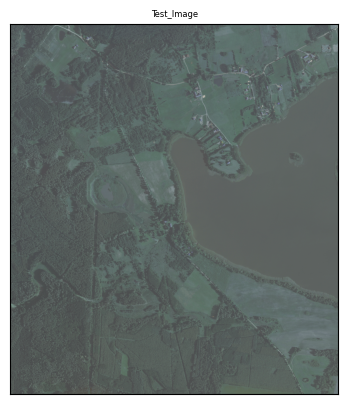

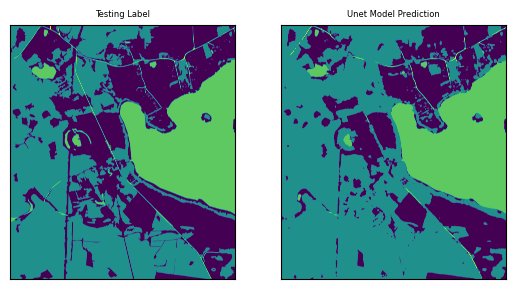

In [18]:
fig1, axis1 = plt.subplots(1, 1)
test_image = cv2.imread(os.path.join(test_img_dir, test_img_list[img_num]), 1)
axis1.imshow(test_image)
axis1.set_title('Test_Image', fontsize = 6)
axis1.axes.xaxis.set_visible(False)
axis1.axes.yaxis.set_visible(False)

fig2, axis2 = plt.subplots(1, 2)
test_mask = tiff.imread(os.path.join(test_mask_dir, test_mask_list[img_num]))
axis2[0].imshow(test_mask)
axis2[0].set_title("Testing Label", fontsize = 6)
axis2[0].axes.xaxis.set_visible(False)
axis2[0].axes.yaxis.set_visible(False)

axis2[1].imshow(my_unet_predictions[img_num])
axis2[1].set_title("Unet Model Prediction", fontsize = 6)
axis2[1].axes.xaxis.set_visible(False)
axis2[1].axes.yaxis.set_visible(False)
    
plt.show()